In [1]:
####################################################################################
# this code defines function to create edges for specific drainage basin
# edgesは2都市間のupstreamとdownstreamの関係をすべて保存したリスト
####################################################################################

import os
import numpy as np
import json
from collections import defaultdict, deque

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as mticker

##########################################################
# kinshana river basin
# hydrabad=citynum(40)
# 19 cities
riv_num = 64
uid_str = f"{riv_num}.0"
distance = 100
##########################################################

h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
basin_cities_path = f'{h08dir}/global_city/dat/riv_num_/basin_to_cities_{distance}km.json'

with open(basin_cities_path, 'r') as json_file:
    new_basin_to_cities = json.load(json_file)
    
def geography(left, right, bottom, top):
    #
    resolution = 12
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent
    
def grid_to_latlon(row, col, extent):
    delta = 360/4320
    x_left, y_top = extent[0], extent[3]
    lon = x_left + (col+0.5) * delta
    lat = y_top - (row+0.5) * delta
    return lon, lat
    
def l_coordinate_to_tuple(lcoordinate, a=2160, b=4320):
    lat_l = ((lcoordinate - 1) // b)
    lon_l = (lcoordinate) % b - 1
    return (lat_l, lon_l)

def nxtl2nxtxy(rgnfile, upperindex, leftindex):
    vfunc = np.vectorize(l_coordinate_to_tuple, otypes=[tuple])
    riv_nxtxy = np.empty(rgnfile.shape, dtype=tuple)
    mask = ~np.isnan(rgnfile)
    riv_nxtxy[mask] = vfunc(rgnfile[mask])
    riv_nxtxy_shape = (riv_nxtxy.shape[0], riv_nxtxy.shape[1], 2)
    
    riv_nxtxy_lst = []
    for row in riv_nxtxy:
        for y, x in row:
            modified_y = y - upperindex
            modified_x = x - leftindex
            riv_nxtxy_lst.append((modified_y, modified_x))

    riv_nxtxy_cropped = np.array(riv_nxtxy_lst).reshape(riv_nxtxy_shape)
    riv_nxtxy_cropped = riv_nxtxy_cropped.astype(int)
    return riv_nxtxy_cropped

def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3):
    projection = ccrs.PlateCarree()
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows-1):
        for j in range(cols-1):
            if mask_cropped[i, j] != 0:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right

    return ax

In [2]:
def get_rivpath(riv_num, sorted_order, upperindex, lowerindex, leftindex, rightindex):
    """riv_num内の全riv_pathとriv_num外のriv_pathのすべてを表示する"""
    
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    
    prf_dir = f'{h08dir}/camacity/dat/cty_prf_'
    prf_path = f'{prf_dir}/prf_clrd0000.gl5'
    prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
    
    swg_dir = f'{h08dir}/camacity/dat/cty_swg_'
    swg_path = f'{swg_dir}/swg_clrd0000.gl5'
    swg = np.fromfile(swg_path, dtype='float32').reshape(2160, 4320)
    
    #int_dir = f'{h08dir}/camacity/dat/cty_aqd_/100km_samebasin'
    int_dir = f'{h08dir}/camacity/dat/cty_aqd_/100km_elevation'
    
    # rivnxl in xy coord
    rivnxl_path = f"{h08dir}/global_city/dat/riv_nxl_/rivnxl.CAMA.gl5"
    rivnxl = np.fromfile(rivnxl_path, 'float32').reshape(2160, 4320)
    rivnxl_cropped = rivnxl[upperindex:lowerindex, leftindex:rightindex]
    riv_nxlonlat_cropped = nxtl2nxtxy(rivnxl_cropped, upperindex, leftindex)

    # rivara
    rivara_path = f'{h08dir}/global_city/dat/riv_ara_/rivara.CAMA.gl5'
    rivara = np.fromfile(rivara_path, 'float32').reshape(2160, 4320)
    rivara_cropped = rivara[upperindex:lowerindex, leftindex:rightindex]
    
    # rivnum
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
    rivnum = rivnum.astype(int)
    rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]

    # rivout
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex]

    # city_numをkeyにしてprfまたはintの下流になるrivpathを保存
    rivpath_dict = {}

    # city loop
    for city_num in sorted_order:
        city_num_dict = {}
        coord_list = []
        
        prf_masked = np.where(prf==city_num, 1, 0)
        swg_masked= np.where(swg==city_num, 1, 0)
        int_path = f'{int_dir}/city_{city_num:08}.gl5'
        
        if np.sum(prf_masked) < 1:
            print(f'{city_num} is invalid prf')
            
        else:
            prf_cropped = prf_masked[upperindex:lowerindex, leftindex:rightindex]
            swg_cropped = swg_masked[upperindex:lowerindex, leftindex:rightindex]
            intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
            intake_cropped = intake[upperindex:lowerindex, leftindex:rightindex]

            coord_list.append(np.where(prf_cropped == 1))
            coord_list.append(np.where(swg_cropped == 1))
            coord_list.append(np.where(intake_cropped == 1))

        # downstream exploration
        count = 0
        for srcd in coord_list:
            yyy = srcd[0]
            xxx = srcd[1]
            for y, x in zip(yyy, xxx):
                target_coord = (y, x) 
            
                path_coords = [target_coord]
                visited_coords = set()
                
                while True:
                    if target_coord in visited_coords:
                        break
                    visited_coords.add(target_coord)
                    target_row, target_col = target_coord
                    next_coord = riv_nxlonlat_cropped[target_row, target_col]
                    if next_coord.size == 0 or next_coord.shape != (2,):
                        break
                    target_coord = (next_coord[0], next_coord[1])
                    path_coords.append(target_coord)
                city_num_dict[count] = path_coords
                count += 1

        # upstream exploration
        for srcd in coord_list:
            yyy = srcd[0]
            xxx = srcd[1]
            for y, x in zip(yyy, xxx):
                target_coord = (y, x)
                
                path_coords = [target_coord]
                visited_coords = set()

                while True:
                    if target_coord in visited_coords:
                        break
                    visited_coords.add(target_coord)
                    matched_coords = np.argwhere(
                        np.all(target_coord == riv_nxlonlat_cropped, axis=2)
                    )
                    if len(matched_coords) == 0:
                        break
                    unvisited_matched = [
                        tuple(coord) for coord in matched_coords if tuple(coord) not in visited_coords
                    ]
                    if not unvisited_matched:
                        break
                    rivara_values = [
                        rivara_cropped[coord[0], coord[1]] for coord in unvisited_matched
                    ]
                    max_index = np.argmax(rivara_values)
                    best_coord = unvisited_matched[max_index]
                    target_coord = best_coord
                    path_coords.append(target_coord)
                city_num_dict[count] = path_coords
                count += 1
            
        # add dict
        rivpath_dict[city_num] = city_num_dict
    
    return rivpath_dict


In [3]:
def process_city_data(riv_num, order, upperindex, lowerindex, leftindex, rightindex, rivnum_cropped, distance=100):
    """
    Process city data based on primary and secondary coordinates in specified masks.

    Parameters:
    - riv_num (int): River number for filtering.
    - order (list): List of city numbers to process.
    - upperindex, lowerindex, leftindex, rightindex (int): Indices for cropping arrays.
    - rivnum_cropped (np.array): Cropped river number array.
    - distance (int): Distance parameter for intake data path.

    Returns:
    - dict: Contains dictionaries for primary and secondary coordinates, and sub_rivnum_list.
    """
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    uid_int = int(riv_num)
    pprf_dct = {}
    sprf_dct = {}
    ibt_dct = {}
    pswg_dct = {}
    sswg_dct = {}
    sub_rivnum_list = []
    
    # Load PRF and SWG data
    prf_dir = f'{h08dir}/camacity/dat/cty_prf_'
    prf_path = f'{prf_dir}/prf_clrd0000.gl5'
    prf = np.fromfile(prf_path, dtype='float32').reshape(2160, 4320)
    
    swg_dir = f'{h08dir}/camacity/dat/cty_swg_'
    swg_path = f'{swg_dir}/swg_clrd0000.gl5'
    swg = np.fromfile(swg_path, dtype='float32').reshape(2160, 4320)

    # Process each city
    for city_num in order:
        # Mask and crop PRF, SWG, and intake data
        prf_masked = np.where(prf == city_num, 1, 0)
        prf_cropped = prf_masked[upperindex:lowerindex, leftindex:rightindex]
        
        swg_masked = np.where(swg == city_num, 1, 0)
        swg_cropped = swg_masked[upperindex:lowerindex, leftindex:rightindex]
        
        #int_dir = f'{h08dir}/camacity/dat/cty_aqd_/{distance}km_samebasin'
        int_dir = f'{h08dir}/camacity/dat/cty_aqd_/100km_elevation'
        int_path = f'{int_dir}/city_{city_num:08}.gl5'
        intake = np.fromfile(int_path, dtype='float32').reshape(2160, 4320)
        intake_cropped = intake[upperindex:lowerindex, leftindex:rightindex]

        # Identify coordinates
        # 1. pprf_coord: prf in uid
        # 2. sprf_coord: prf not in uid
        # 3. pswg_coord: swg in uid
        # 4. sswg_coord: swg not in uid
        # 5. pint_coord: intake in uid
        # 6. sint_coord: intake not in uid
        pprf_coord = np.where((prf_cropped == 1) & (rivnum_cropped == uid_int))
        sprf_coord = np.where((prf_cropped == 1) & (rivnum_cropped != uid_int))
        pswg_coord = np.where((swg_cropped == 1) & (rivnum_cropped == uid_int))
        sswg_coord = np.where((swg_cropped == 1) & (rivnum_cropped != uid_int))
        pint_coord = np.where((intake_cropped == 1) & (rivnum_cropped == uid_int))
        sint_coord = np.where((intake_cropped == 1) & (rivnum_cropped != uid_int))

        # Remove empty secondary points
        sprf_coord = None if sprf_coord[0].size == 0 else sprf_coord
        sint_coord = None if sint_coord[0].size == 0 else sint_coord
        sswg_coord = None if sswg_coord[0].size == 0 else sswg_coord

        # Update sub_rivnum_list
        if sprf_coord is not None:
            sprf_rn = rivnum_cropped[sprf_coord]
            sub_rivnum_list.extend(np.unique(sprf_rn).tolist())
        
        if sint_coord is not None:
            sint_rn = rivnum_cropped[sint_coord]
            sub_rivnum_list.extend(np.unique(sint_rn).tolist())

        # Determine primary and secondary coordinates
        if pprf_coord[0].size != 0 and pint_coord[0].size != 0:
            primary_prf_coord = pprf_coord
            primary_swg_coord = pswg_coord
            secondary_prf_coord = sprf_coord
            secondary_swg_coord = sswg_coord
            ibt_coord = pint_coord
        elif pprf_coord[0].size != 0 and pint_coord[0].size == 0:
            primary_prf_coord = pprf_coord
            primary_swg_coord = pswg_coord
            secondary_prf_coord = sprf_coord
            secondary_swg_coord = sswg_coord
            ibt_coord = sint_coord
        elif pprf_coord[0].size == 0 and pint_coord[0].size != 0:
            if sprf_coord and len(sprf_coord[0]) == 1:
                primary_prf_coord = sprf_coord
                primary_swg_coord = sswg_coord
                secondary_prf_coord = None
                secondary_swg_coord = None
            else:
                primary_prf_coord = (np.array([sprf_coord[0][0]]), np.array([sprf_coord[1][0]]))
                primary_swg_coord = (np.array([sswg_coord[0][0]]), np.array([sswg_coord[1][0]]))
                secondary_prf_coord = (np.delete(sprf_coord[0], 0), np.delete(sprf_coord[1], 0))
                secondary_swg_coord = (np.delete(sswg_coord[0], 0), np.delete(sswg_coord[1], 0))
            ibt_coord = pint_coord
        else:
            primary_prf_coord = None
            primary_swg_coord = None
            secondary_prf_coord = None
            secondary_swg_coord = None
            ibt_coord = None

        # Store results in dictionaries
        pprf_dct[city_num] = primary_prf_coord
        sprf_dct[city_num] = secondary_prf_coord
        pswg_dct[city_num] = primary_swg_coord
        sswg_dct[city_num] = secondary_swg_coord
        ibt_dct[city_num] = ibt_coord
    
    return pprf_dct, sprf_dct, pswg_dct, sswg_dct, ibt_dct, sub_rivnum_list

city_list: [40, 66, 287, 314, 475, 485, 708, 778, 852, 894, 940, 1000, 1106, 1174, 1255, 1429, 1478, 1493, 1758]
city_list_removed: [40, 66, 287, 314, 475, 485, 708, 778, 852, 894, 1000, 1106, 1174, 1255, 1429, 1493, 1758]
sub_rivnum_list: [  53.  273. 2219. 2645. 5127.]


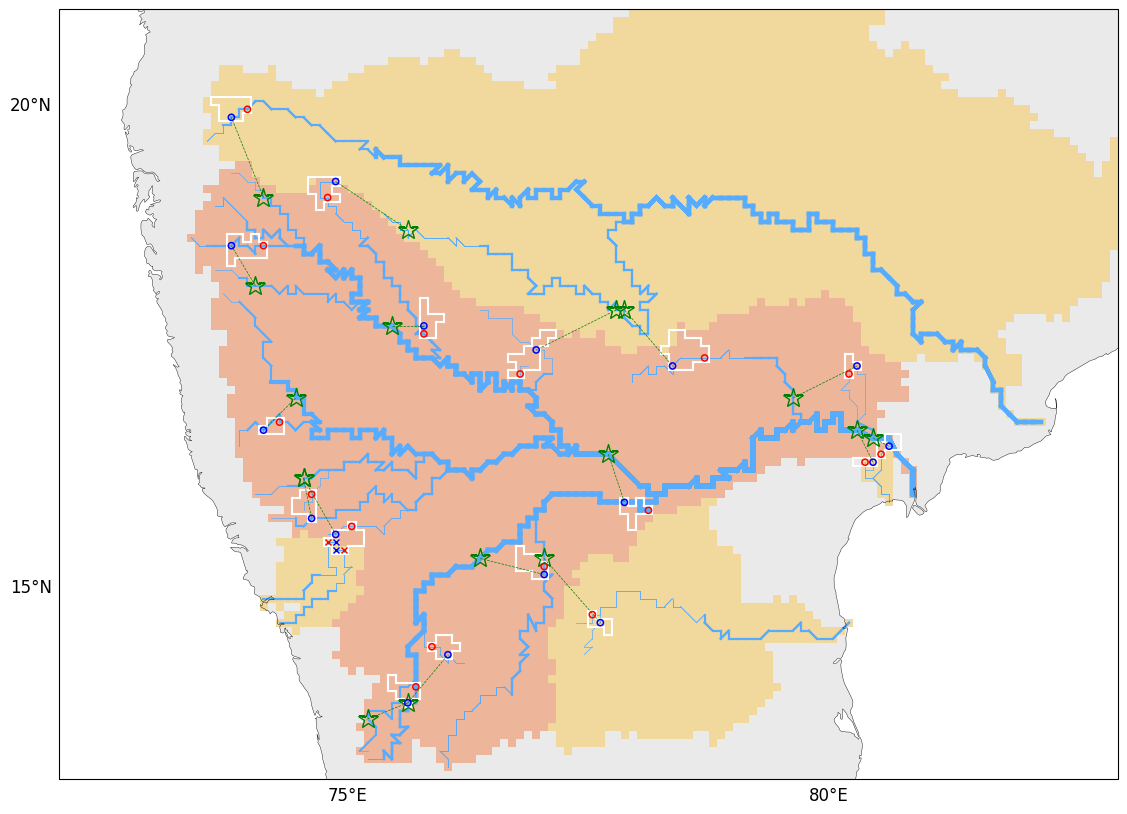

In [8]:
def draw_product(riv_num):
    #
    ctymsk_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/cty_msk_/city_clrd0000.gl5'
    basin_cities_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/riv_num_/basin_to_cities_100km.json'
    with open(basin_cities_path, 'r') as json_file:
        new_basin_to_cities = json.load(json_file)
    #
    key_index = 64
    left = 70
    right = 85
    bottom = 10
    top = 25
    #
    resolution=12
    nx, ny = (right - left)*resolution, (top - bottom)*resolution
    rgnshape = (ny, nx)
    img_extent = (left, right, bottom, top)
    extent = (-180, 180, -90, 90)
    #
    upperindex = (90-top)*resolution
    lowerindex = (90-bottom)*resolution
    leftindex = (180+left)*resolution
    rightindex = (180+right)*resolution
    #
    ###########################################################################################
    
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

    # riv
    rivnum_path = f'{h08dir}/global_city/dat/riv_num_/rivnum.CAMA.gl5'
    rivnum = np.fromfile(rivnum_path, dtype='float32').reshape(2160, 4320) 
    rivnum_cropped = rivnum[upperindex:lowerindex, leftindex:rightindex]
    rivnum_masked = np.ma.masked_where(rivnum_cropped != riv_num, rivnum_cropped)
    
    # discharge
    rivout_path = f'{h08dir}/wsi/dat/riv_out_/W5E5LR__00000000.gl5'
    rivout = np.fromfile(rivout_path, dtype='float32').reshape(2160, 4320)
    rivout_cropped = rivout[upperindex:lowerindex, leftindex:rightindex] * 60 * 60 * 24 * 365 / 1000

    # lonlat
    lonlat_path = f'{h08dir}/wsi/dat/cmy/cmy_citylonlat.npy'
    citylonlat = np.load(lonlat_path)

    nums = citylonlat[:, 0]
    lons = citylonlat[:, 1]
    lats = citylonlat[:, 2]

    # order
    uid_str = f"{riv_num}.0"
    city_list = new_basin_to_cities[uid_str]
    city_list = [int(i) for i in city_list]
    print(f'city_list: {city_list}')
    # remove overlap
    overlap_path = f'{h08dir}/global_city/dat/cty_lst_/gpw4/overlap_hidden_only.txt'
    with open(overlap_path, 'r') as f:
        numbers = [int(line.strip()) for line in f]
    # nashiki
    #numbers.append(287)
    city_list_removed = [num for num in city_list if num not in numbers]
    city_list_removed = [int(i) for i in city_list_removed]
    print(f'city_list_removed: {city_list_removed}')
    order = city_list_removed
    
    order_index = []
    for cnm in order:
        idx = np.where(np.array(nums) == cnm)[0]
        order_index.append(idx)

    # lon lat
    target_lons = lons[order_index]
    target_lats = lats[order_index]
    
    # rivnxl
    path_dict = get_rivpath(riv_num, order, upperindex, lowerindex, leftindex, rightindex)

    # coord dct
    pprf_dct, sprf_dct, pswg_dct, sswg_dct, ibt_dct, sub_rivnum_list = process_city_data(
        riv_num, order, upperindex, lowerindex, leftindex, rightindex, rivnum_cropped, distance=100,
    )
    sub_rivnum_list = np.unique(sub_rivnum_list)
    print(f'sub_rivnum_list: {sub_rivnum_list}')

    ###########################################################################################
    
    # cmap
    bounds = [0, 1000]
    cmap = mcolors.ListedColormap(['blue', 'blue'])
    norm = mcolors.BoundaryNorm(bounds, cmap.N)
    
    rivnum_cmap = mcolors.ListedColormap(['#edb69b'])
    srivnum_cmap = mcolors.ListedColormap(['#f1d89c'])
    river_cmap = mcolors.ListedColormap(['#57acff'])

    # draw
    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(20,10), subplot_kw={'projection': projection})
    ax.set_extent([left, right, bottom, top], projection)

    # rivnxl
    width = 1
    for city_num in order:
        path_city_dict = path_dict[city_num]
        
        for key, path_coords in path_city_dict.items():
            
            #2つずつのペアに変換
            path_coords_lat = [coord[0] for coord in path_coords]
            path_coords_lon = [coord[1] for coord in path_coords]
            path_coords_pairs = list(zip(path_coords_lat, path_coords_lon))
            path_coords_grouped = [(path_coords_lat[i:i + 2], path_coords_lon[i:i + 2]) for i in range(len(path_coords) - 1)]
            
            for lat_coords, lon_coords in path_coords_grouped:
                # dischargeの取得
                discharge = rivout_cropped[lat_coords[0], lon_coords[0]]
                ###########################################################################################
                # discharge criteria
                ###########################################################################################
                if discharge > 1e10:
                    linewidth = 3.0
                elif 1e10 > discharge > 1e9:
                    linewidth = 1.5
                else:
                    linewidth = 0.5
                
                # lat_coordsとlon_coordsの変換
                lat_coords = [img_extent[3] - ((lat + (1/(width * 2)))*(1/12)) for lat in lat_coords]
                lon_coords = [(lon + (1/(width * 2)))*(1/12) + img_extent[0] for lon in lon_coords]
                
                # ax.plotを使ってプロット
                ax.plot(lon_coords, lat_coords, 
                        markersize=0, linewidth=linewidth, color='#57acff',
                        marker='o', linestyle='-', transform=projection, zorder=1
                       )

    # rivnum
    bg = ax.imshow(rivnum_masked, 
                   alpha=1, cmap=rivnum_cmap, transform=projection, extent=img_extent
                  )

    for srn in sub_rivnum_list:
        srivnum_masked = np.ma.masked_where(rivnum_cropped != srn, rivnum_cropped)
        ax.imshow(srivnum_masked, 
                  alpha=1, cmap=srivnum_cmap, transform=projection, extent=img_extent
                  )

    # city outer
    citymask_original = np.fromfile(ctymsk_path, dtype='float32').reshape(2160, 4320)
    for city_num in order:
        citymask = np.where(citymask_original == int(city_num), 1, 0)
        citymask_cropped = citymask[upperindex:lowerindex, leftindex:rightindex]
        draw_mask_sotowaku(img_extent, citymask_cropped, ax=ax, sotowaku_color='white', linewidth=1.5)
        
    # prf
    pprf_latlon = [
        grid_to_latlon(coord[0][0], coord[1][0], img_extent)
        for _, coord in pprf_dct.items()
        if coord is not None and len(coord) > 1
    ]
    pprf_lon, pprf_lat = zip(*pprf_latlon)
    ax.scatter(pprf_lon, pprf_lat, s=20, facecolors='none', linewidths=1.1,
            color='blue', transform=ccrs.PlateCarree(), zorder=3)

    # swg
    pswg_latlon = [
        grid_to_latlon(coord[0][0], coord[1][0], img_extent)
        for _, coord in pswg_dct.items()
        if coord is not None and len(coord) > 1
    ]
    pswg_lon, pswg_lat = zip(*pswg_latlon)
    ax.scatter(pswg_lon, pswg_lat, s=20, facecolors='none', linewidths=1.1,
            color='red', transform=ccrs.PlateCarree(), zorder=3)

    # int
    int_latlon = [
        grid_to_latlon(coord[0][0], coord[1][0], img_extent) if coord is not None else (None, None) 
        for n, coord in ibt_dct.items()
    ]
    for lon, lat in int_latlon:
        if lon is not None and lat is not None:
            ax.plot(lon, lat, marker='*', color='green', markersize=15, 
                    markerfacecolor='None', markeredgecolor='green', markeredgewidth=1.0,
                    linestyle='None', transform=ccrs.PlateCarree(), zorder=2)

    # arrow
    for int_latlon, prf_latlon in zip(int_latlon, pprf_latlon):
        if int_latlon[0] is not None and int_latlon[1] is not None:
            start_lon, start_lat = int_latlon[0], int_latlon[1]
            end_lon, end_lat = prf_latlon[0], prf_latlon[1]
            ax.plot([start_lon, end_lon], [start_lat, end_lat], color='green', 
                    linestyle='--', linewidth=0.5, transform=ccrs.PlateCarree(), zorder=1)

    # secondary prf
    sprf_latlon = [
        [grid_to_latlon(c[0], c[1], img_extent) for c in zip(coord[0], coord[1])] if coord is not None else [(None, None)] 
        for n, coord in sprf_dct.items()
    ]
    
    for coord_list in sprf_latlon:
        for lon, lat in coord_list:
            if lon is not None and lat is not None:
                ax.plot(lon, lat, marker='x', color='blue', markersize=5, 
                        transform=ccrs.PlateCarree(), zorder=2)
                
    # secondary swg
    sswg_latlon = [
        [grid_to_latlon(c[0], c[1], img_extent) for c in zip(coord[0], coord[1])] if coord is not None else [(None, None)] 
        for n, coord in sswg_dct.items()
    ]
    
    for coord_list in sswg_latlon:
        for lon, lat in coord_list:
            if lon is not None and lat is not None:
                ax.plot(lon, lat, marker='x', color='red', markersize=5, 
                        transform=ccrs.PlateCarree(), zorder=2)

    ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#eaeaea', zorder=-3)
    ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#ffffff')
    ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#ffffff', zorder=-1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.3,edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1.5, edgecolor='#d0cfd4', zorder=-3)
    ax.gridlines(visible=False)

    west, east, south, north = 72, 83, 13, 21
    ax.set_xlim(west, east)
    ax.set_ylim(south, north)
    
    gl = ax.gridlines(draw_labels=True, zorder=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlocator = mticker.FixedLocator(np.arange(round(west/10)*10, east, 5))
    gl.ylocator = mticker.FixedLocator(np.arange(round(south/10)*10, north, 5))
    gl.top_labels = False
    gl.right_labels = False
    gl.bottom_labels = True
    gl.left_labels = True
    gl.xlines = False
    gl.ylines = False
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    ax.gridlines(visible=False)
    ax.spines['geo'].set_visible(True)
    
    plt.show()

riv_num = 64
draw_product(riv_num)